# Multi-head Attention Model


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# import data from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/fake reviews dataset.csv')
df.head(3)

Mounted at /content/drive


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...


In [ ]:
label_mapping = {"CG": 1, "OR": 0}

# Map labels to numerical values
df['label'] = [label_mapping[label] for label in df['label']]

### Some basic facts of the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  int64  
 3   text_     40432 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.2+ MB


### Pre-processing steps to sanitize/manipulate/combine your dataset(s)

### Machine learning models that you have used (E.g., Unsupervised? Supervised?)(Somewhat an extension of (5) of project proposal)

In [ ]:
sentences = df['text_']
label = df['label']

# Train-test-split
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# Tokenization
max_len = 512
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

# Encoding of Inputs
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

Vocab Size:  39143


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 512  #changed
vocab_size = 39143  #changed

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 token_and_position_embeddi  (None, 512, 50)           1982750   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 512, 50)           23832     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

# Val Loss Min

In [ ]:
model_name = "model_02.h5"
checkpoint = ModelCheckpoint("best_model_loss_new.h5",
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            dirpath= '/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection',  # Directory to save the checkpoints
                            verbose=1)

#earlystopping = EarlyStopping(monitor='val_acc',min_delta = 0.001, patience = 1, verbose = 1)

#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            #patience=3,
                                            #verbose=1,
                                           # factor=0.2,
                                            #min_lr=0.00000001)

In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=5,
                    batch_size=32,
                    callbacks=[checkpoint])

Epoch 1/5
1009/1011 [============================>.] - ETA: 0s - loss: 0.0308 - accuracy: 0.9893
Epoch 1: val_loss improved from inf to 0.34526, saving model to best_model_loss_new.h5
1011/1011 [==============================] - 19s 19ms/step - loss: 0.0307 - accuracy: 0.9892 - val_loss: 0.3453 - val_accuracy: 0.9347
Epoch 2/5
   1/1011 [..............................] - ETA: 18s - loss: 0.0088 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1009/1011 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9907
Epoch 2: val_loss improved from 0.34526 to 0.32255, saving model to best_model_loss_new.h5
1011/1011 [==============================] - 19s 19ms/step - loss: 0.0279 - accuracy: 0.9907 - val_loss: 0.3225 - val_accuracy: 0.9337
Epoch 3/5
1009/1011 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9912
Epoch 3: val_loss did not improve from 0.32255
1011/1011 [==============================] - 19s 18ms/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 0.3582 - val_accuracy: 0.9359
Epoch 4/5
1008/1011 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9918
Epoch 4: val_loss did not improve from 0.32255
1011/1011 [==============================] - 18s 18ms/step - loss: 0.0243 - accuracy: 0.9918 - val_loss: 0.3839 - val_accuracy: 0.9342
Epoch 5/5
1010/1011 [============================>.] - ETA: 0s - loss: 0.0213 - accuracy: 0.9923
Epoch 5: val_loss did not improv

In [ ]:
import numpy as np

y_pred_probs = model.predict(X_test)

threshold = 0.5
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 93.31%
Recall: 93.18%
F1_score: 93.24%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2022
           1       0.93      0.93      0.93      2022

    accuracy                           0.93      4044
   macro avg       0.93      0.93      0.93      4044
weighted avg       0.93      0.93      0.93      4044



### Load the best model for analysis

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# Define the TokenAndPositionEmbedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Load the saved model
best_model = load_model("/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/best_model_loss_new.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerEncoder": TransformerEncoder})



In [ ]:
import numpy as np

y_pred_probs = best_model.predict(X_test)

threshold = 0.5
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 93.84%
Recall: 93.84%
F1_score: 93.84%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2022
           1       0.94      0.94      0.94      2022

    accuracy                           0.94      4044
   macro avg       0.94      0.94      0.94      4044
weighted avg       0.94      0.94      0.94      4044



In [ ]:
import numpy as np

y_pred_probs = best_model.predict(X_test)

threshold = 0.75
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 93.81%
Recall: 93.79%
F1_score: 93.79%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2022
           1       0.95      0.93      0.94      2022

    accuracy                           0.94      4044
   macro avg       0.94      0.94      0.94      4044
weighted avg       0.94      0.94      0.94      4044



In [ ]:
#plt.figure(figsize=(20,8))
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'val'], loc='upper left')
#plt.show()

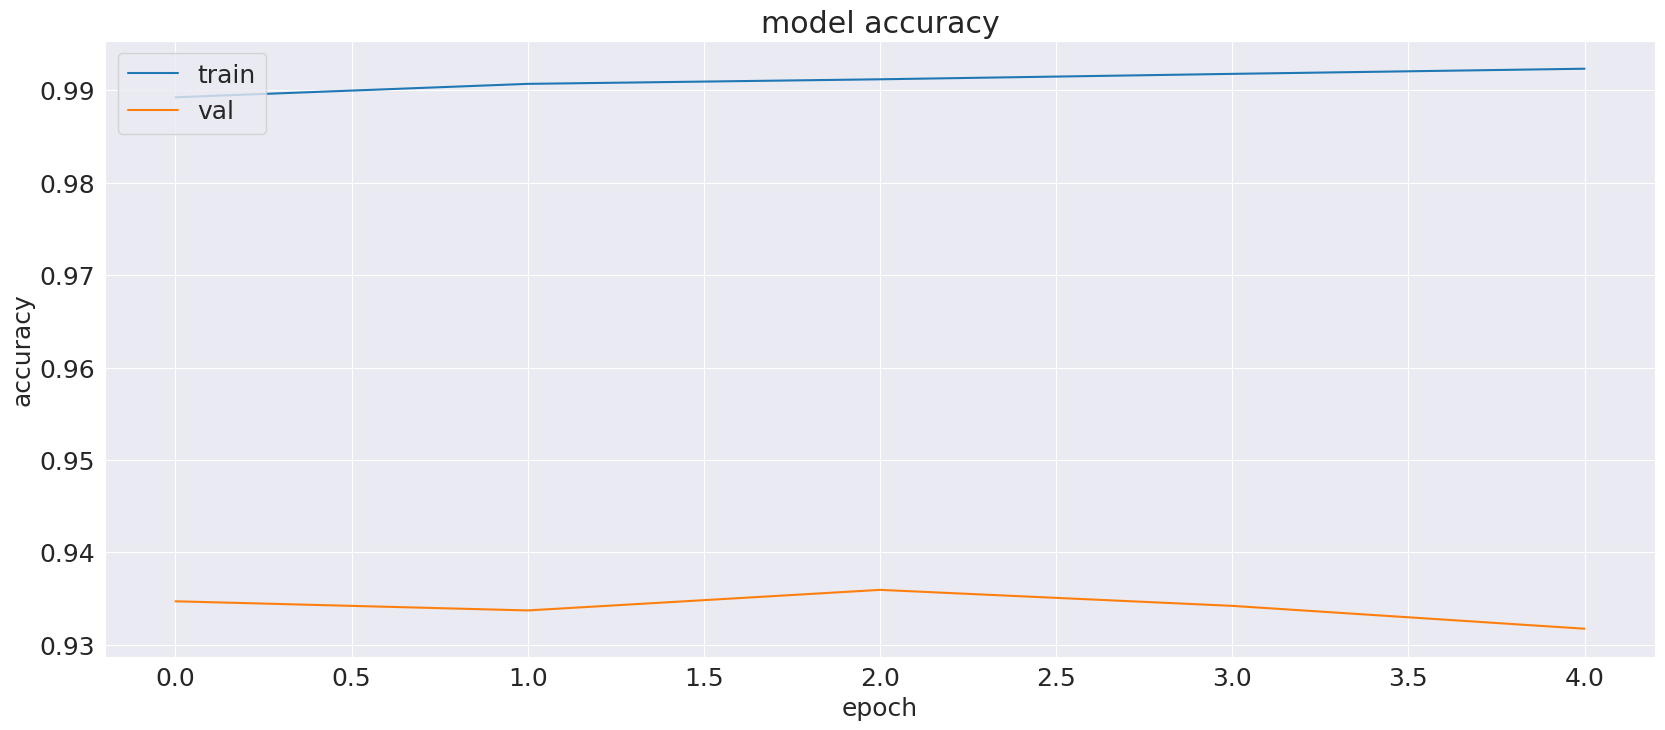

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

127/127 [==============================] - 1s 7ms/step


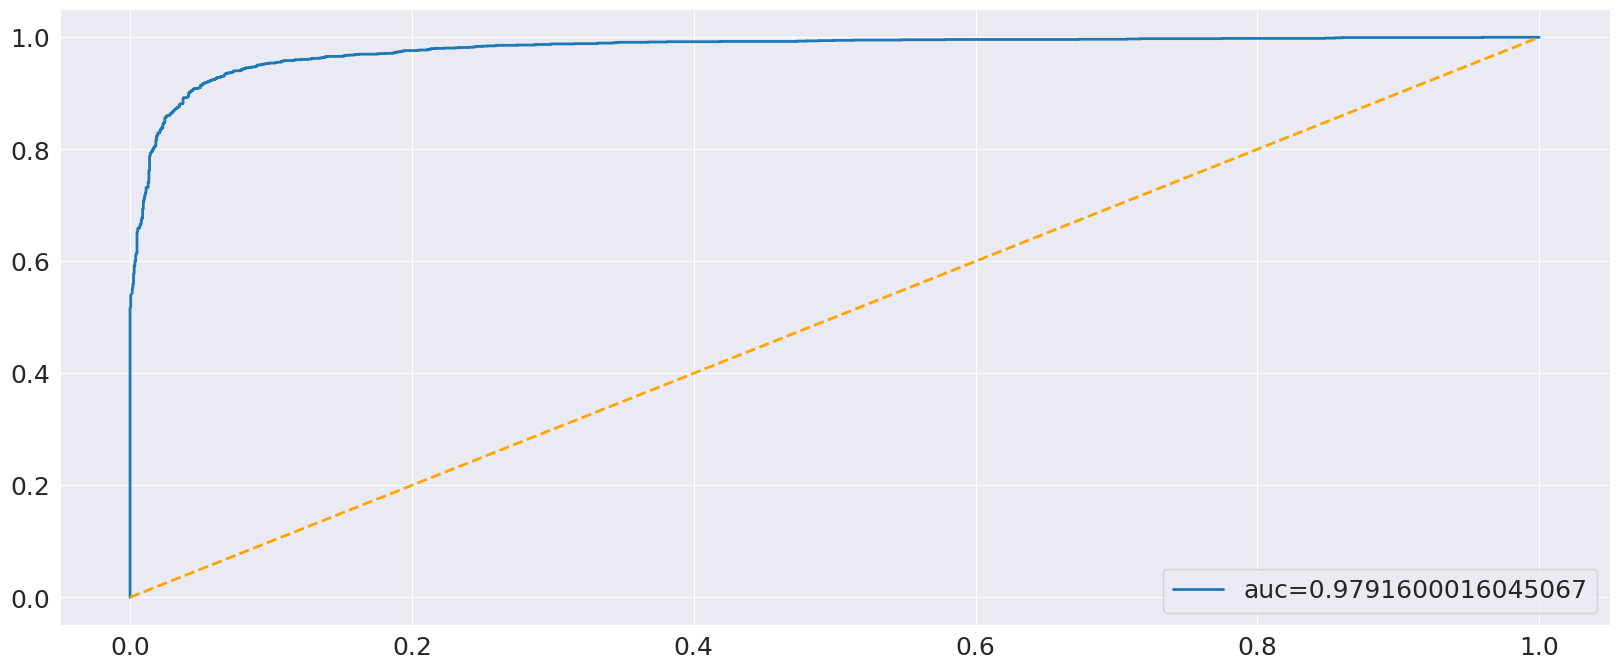

In [ ]:
# Test Result
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# ROC Curve
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [ ]:
# Scores: Test Set Result
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2022
           1       0.94      0.92      0.93      2022

    accuracy                           0.93      4044
   macro avg       0.93      0.93      0.93      4044
weighted avg       0.93      0.93      0.93      4044



<Axes: >

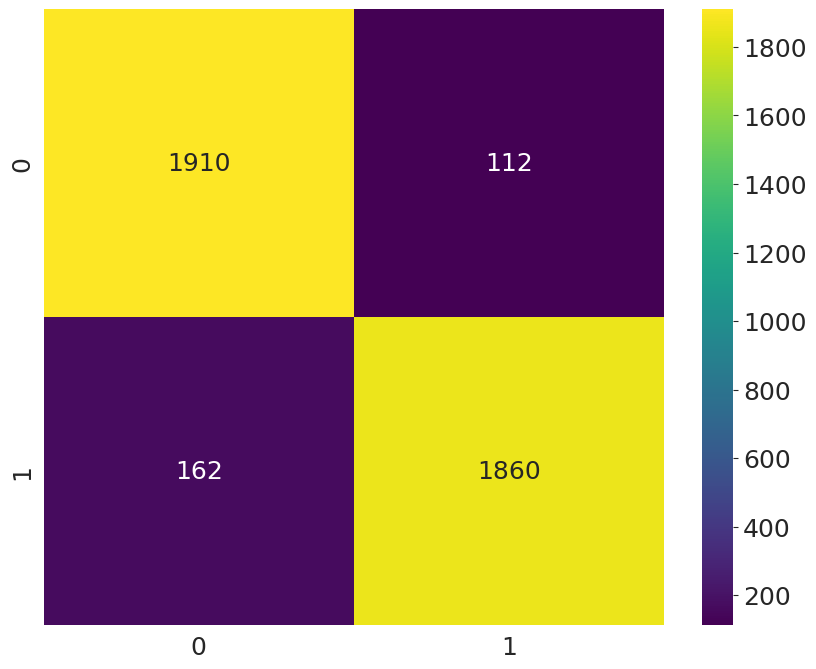

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')

### The insights that you have gathered from applying machine learning methods on the dataset(s)


In [ ]:
import pandas as pd

predicted_classes_df = pd.DataFrame(y_pred_classes, columns=["Predicted_Class"])
predicted_classes_df.index = y_test.index

if isinstance(y_test, pd.Series):
    y_test_df = y_test.to_frame(name='Actual_Class')
else:
    y_test_df = y_test

df = y_test_df.join(predicted_classes_df)

path = "/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_New_MINLOSS.csv"

df.to_csv(path, index=True)

print(path)


/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_New_MINLOSS.csv


# Accuracy Max

In [ ]:
from tensorflow.keras import metrics
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=[metrics.F1Score(average='weighted'),metrics.Precision(),metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 token_and_position_embeddi  (None, 512, 50)           1982750   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 512, 50)           23832     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

In [ ]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/best_model_loss_new.h5",
                            monitor="val_f1_score",
                            mode="max",
                            save_best_only=True,
                            verbose=1)


#earlystopping = EarlyStopping(monitor='val_f1_score',min_delta = 0.001, patience = 1, verbose = 1)

#learning_rate_reduction = ReduceLROnPlateau(monitor='val_f1_score',
                                           # patience=3,
                                           # verbose=1,
                                           # factor=0.2,
                                           # min_lr=0.00000001)

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=5,
                    batch_size=32,
                    callbacks=[checkpoint])

Epoch 1/5
1011/1011 [==============================] - ETA: 0s - loss: 0.0223 - f1_score: 0.6667 - precision_1: 0.9930 - recall_1: 0.9920
Epoch 1: val_f1_score improved from -inf to 0.66656, saving model to /content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/best_model_acc_new.h5
1011/1011 [==============================] - 58s 53ms/step - loss: 0.0223 - f1_score: 0.6667 - precision_1: 0.9930 - recall_1: 0.9920 - val_loss: 0.4307 - val_f1_score: 0.6666 - val_precision_1: 0.9211 - val_recall_1: 0.9416
Epoch 2/5
   1/1011 [..............................] - ETA: 18s - loss: 0.0015 - f1_score: 0.7692 - precision_1: 1.0000 - recall_1: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1008/1011 [============================>.] - ETA: 0s - loss: 0.0193 - f1_score: 0.6667 - precision_1: 0.9936 - recall_1: 0.9936
Epoch 2: val_f1_score did not improve from 0.66656
1011/1011 [==============================] - 26s 26ms/step - loss: 0.0193 - f1_score: 0.6667 - precision_1: 0.9936 - recall_1: 0.9935 - val_loss: 0.4356 - val_f1_score: 0.6666 - val_precision_1: 0.9241 - val_recall_1: 0.9342
Epoch 3/5
1009/1011 [============================>.] - ETA: 0s - loss: 0.0168 - f1_score: 0.6666 - precision_1: 0.9952 - recall_1: 0.9946
Epoch 3: val_f1_score did not improve from 0.66656
1011/1011 [==============================] - 22s 22ms/step - loss: 0.0168 - f1_score: 0.6667 - precision_1: 0.9952 - recall_1: 0.9946 - val_loss: 0.5297 - val_f1_score: 0.6666 - val_precision_1: 0.9387 - val_recall_1: 0.9020
Epoch 4/5
1009/1011 [============================>.] - ETA: 0s - loss: 0.0151 - f1_score: 0.6667 - precision_1: 0.9954 - recall_1: 0.9947
Epoch 4: val_f1_score did not improve from 0

In [ ]:
import numpy as np

y_pred_probs = model.predict(X_test)

threshold = 0.5
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 92.36%
Recall: 92.31%
F1_score: 92.31%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2022
           1       0.94      0.91      0.92      2022

    accuracy                           0.92      4044
   macro avg       0.92      0.92      0.92      4044
weighted avg       0.92      0.92      0.92      4044



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

# Define the TokenAndPositionEmbedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the TransformerEncoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Load the saved model
best_model = load_model("/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/best_model_acc_new.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerEncoder": TransformerEncoder})

In [ ]:
import numpy as np

y_pred_probs = best_model.predict(X_test)

threshold = 0.5
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 93.43%
Recall: 93.42%
F1_score: 93.42%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2022
           1       0.93      0.94      0.93      2022

    accuracy                           0.93      4044
   macro avg       0.93      0.93      0.93      4044
weighted avg       0.93      0.93      0.93      4044



### Test threshold 0.75

In [ ]:
import numpy as np

y_pred_probs = best_model.predict(X_test)

threshold = 0.75
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(y_test, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(y_test, y_pred_classes))


127/127 [==============================] - 1s 7ms/step
Precision: 93.50%
Recall: 93.50%
F1_score: 93.50%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2022
           1       0.94      0.93      0.93      2022

    accuracy                           0.93      4044
   macro avg       0.93      0.93      0.93      4044
weighted avg       0.93      0.93      0.93      4044



In [ ]:
import pandas as pd

predicted_classes_df = pd.DataFrame(y_pred_classes, columns=["Predicted_Class"])
predicted_classes_df.index = y_test.index

if isinstance(y_test, pd.Series):
    y_test_df = y_test.to_frame(name='Actual_Class')
else:
    y_test_df = y_test

df = y_test_df.join(predicted_classes_df)

path = "/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_New.csv"

df.to_csv(path, index=True)

print(path)


/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_New.csv


In [ ]:
df

,Actual_Class,Predicted_Class
35841,0,0
5609,1,1
13793,0,0
22182,0,0
14093,0,0
...,...,...
1170,0,0
31664,1,1
12327,0,0
13394,1,1


# Test our newly generated dataset

In [ ]:
ind_df = pd.read_csv('/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Independent Data Set/IndependentReviewData_150.csv')
# Load the saved model
best_model = load_model("/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/best_model_loss_new.h5", custom_objects={"TokenAndPositionEmbedding": TokenAndPositionEmbedding, "TransformerEncoder": TransformerEncoder})
ind_df

,Rating,Review,type
0,5.0,This product so far has not disappointed. My c...,real
1,5.0,great for beginner or experienced person. Boug...,real
2,5.0,Inexpensive tablet for him to use and learn on...,real
3,4.0,I've had my Fire HD 8 two weeks now and I love...,real
4,5.0,I bought this for my grand daughter when she c...,real
...,...,...,...
145,1.0,I expected better from this product. It fails ...,fake
146,2.0,"Decent as a backup reader, but it's not suitab...",fake
147,5.0,Excellent Kindle! The screen is crisp and clea...,fake
148,5.0,Best Kindle I've owned. The performance is fla...,fake


In [ ]:
label_mapping = {"fake": 1, "real": 0}

# Map labels to numerical values
ind_df['type'] = [label_mapping[label] for label in ind_df['type']]
ind_df

,Rating,Review,type
0,5.0,This product so far has not disappointed. My c...,0
1,5.0,great for beginner or experienced person. Boug...,0
2,5.0,Inexpensive tablet for him to use and learn on...,0
3,4.0,I've had my Fire HD 8 two weeks now and I love...,0
4,5.0,I bought this for my grand daughter when she c...,0
...,...,...,...
145,1.0,I expected better from this product. It fails ...,1
146,2.0,"Decent as a backup reader, but it's not suitab...",1
147,5.0,Excellent Kindle! The screen is crisp and clea...,1
148,5.0,Best Kindle I've owned. The performance is fla...,1


In [ ]:
sentences = ind_df['Review']
label = ind_df['type']

# Tokenization
max_len = 512
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

# Encoding of Inputs
train_sequences = tokenizer.texts_to_sequences(sentences)
sentences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


Vocab Size:  595


In [ ]:
# test the model
import numpy as np

y_pred_probs = best_model.predict(sentences)

threshold = 0.5
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(label, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(label, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(label, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(label, y_pred_classes))


5/5 [==============================] - 0s 9ms/step
Precision: 78.50%
Recall: 76.67%
F1_score: 76.29%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.86      0.64      0.73        75
           1       0.71      0.89      0.79        75

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.76       150
weighted avg       0.78      0.77      0.76       150



In [ ]:
# test the model
import numpy as np

y_pred_probs = best_model.predict(sentences)

threshold = 0.75
y_pred_classes = (y_pred_probs >= threshold).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(label, y_pred_classes, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
recall = recall_score(label, y_pred_classes, average='weighted')
print('Recall: {:.2f}%'.format(recall * 100))
f1 = f1_score(label, y_pred_classes, average='weighted')
print('F1_score: {:.2f}%'.format(f1 * 100))

print('**********************************************************')
print('*****************  Classification Report  ****************')
print('**********************************************************')
print(classification_report(label, y_pred_classes))


5/5 [==============================] - 0s 8ms/step
Precision: 77.49%
Recall: 76.67%
F1_score: 76.49%
**********************************************************
*****************  Classification Report  ****************
**********************************************************
              precision    recall  f1-score   support

           0       0.82      0.68      0.74        75
           1       0.73      0.85      0.79        75

    accuracy                           0.77       150
   macro avg       0.77      0.77      0.76       150
weighted avg       0.77      0.77      0.76       150



In [ ]:
# generate model with threshold 0.5
import pandas as pd

predicted_classes_df = pd.DataFrame(y_pred_classes, columns=["Predic7ted_Class"])
predicted_classes_df.index = label.index

if isinstance(y_test, pd.Series):
    label_df = label.to_frame(name='Actual_Class')
else:
    label_df = label

df = label_df.join(predicted_classes_df)

path = "/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_Independent_dataset_MINLOSS.csv"

df.to_csv(path, index=True)

print(path)
df

/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/Predicted_Classes_Independent_dataset_MINLOSS.csv


,Actual_Class,Predic7ted_Class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
145,1,0
146,1,1
147,1,1
148,1,1
